## 🌧<b> NB02 - Raininess Index </b>

My Raininiess Index (RI) will be composed of the variable <b> rain sum </b>, as I am trying to see whether London is as rainy as the movies make it out to be (and in general, how rainy it is compared to other rainy cities). So, using rain sum to decide on the raininess makes more sense than using a variable such as precipitation sum, which also includes snow.

#### This will help me make deductions regarding my two hypotheses:

<b> H0: </b> London's raininess is no different than any other generally-rainy city

<b> H1: </b> London is rainier than the other selected cities

In [1]:
## Importing packages
import pandas as pd
import os
import json
import requests
import numpy as np

from functions import *

from lets_plot import *
LetsPlot.setup_html()

import geopandas as gpd

from lets_plot.geo_data import *

import geodatasets

from IPython.display import HTML
from IPython.display import *
from shapely.geometry import Point

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


In [2]:
## Reading London data and renaming rain_sum as raininess (as a test-run, to see if it works)
daily_rain_df = pd.read_json('../data/daily_rain.json')

daily_rain_df = daily_rain_df.rename(columns={'rain_sum': 'raininess'})

daily_rain_df.to_csv('../data/london_rain.csv', index=False)

## Reading the complete city data and renaming rain_sum as raininess
all_city_rain_df = pd.read_csv('../data/historical_city_rain_data.csv')

all_city_rain_df = all_city_rain_df.rename(columns={'rain_sum': 'raininess'})

all_city_rain_df.to_csv('../data/all_city_rain_df.csv', index=False)

## Converting the data into a pandas table and calling the first 5 rows
all_city_rain_df.head()

,country,city,date,raininess
0,GB,London,2021-01-01,0.4
1,GB,London,2021-01-02,0.0
2,GB,London,2021-01-03,0.6
3,GB,London,2021-01-04,2.3
4,GB,London,2021-01-05,2.1


In [3]:
## Taking the date column and merging days together to create a year_month column with corresponding monthly mean raininess values
all_city_rain_df['date'] = pd.to_datetime(all_city_rain_df['date'], errors='coerce')

all_city_rain_df['year_month'] = all_city_rain_df['date'].dt.to_period('M') 

monthly_avg = all_city_rain_df.groupby(['city', 'year_month'])['raininess'].mean().reset_index()

monthly_avg.rename(columns={'raininess': 'monthly_mean_raininess'}, inplace=True)

## Printing df to check for errors
print(monthly_avg)

monthly_avg.to_csv('../data/monthly_avg.csv', index=False)
monthly_avg = pd.read_csv('/files/ds105a-2024-w06-summative-deyavuz/data/monthly_avg.csv')

        city year_month  monthly_mean_raininess
0      Kyoto    2021-01                2.209677
1      Kyoto    2021-02                2.303571
2      Kyoto    2021-03                4.651613
3      Kyoto    2021-04                7.000000
4      Kyoto    2021-05                9.970968
..       ...        ...                     ...
180  Seattle    2023-09                2.620000
181  Seattle    2023-10                2.754839
182  Seattle    2023-11                4.773333
183  Seattle    2023-12                6.887097
184  Seattle    2024-01                0.000000

[185 rows x 3 columns]


To visualize the monthly mean raininess of all 5 cities, I plotted them on the below line graph. However, as it didn't provide a clear, comprehensive picture of the situation, I decided to compare Kyoto, which visually has the highest raininess means, with London, our research focus.

In [15]:
## Plotting every city's mean raininess on a line graph
plot = (
    ggplot(monthly_avg, aes(x='year_month', y='monthly_mean_raininess', group='city')) + \
    geom_line(aes(color='city'), size=1, alpha=0.5) + \
    xlab('Year and Month') + \
    ylab('Monthly Mean Raininess') + \
        ggtitle('Figure 2. Monthly Mean Raininess for Each City Between 2021-2024'))
plot

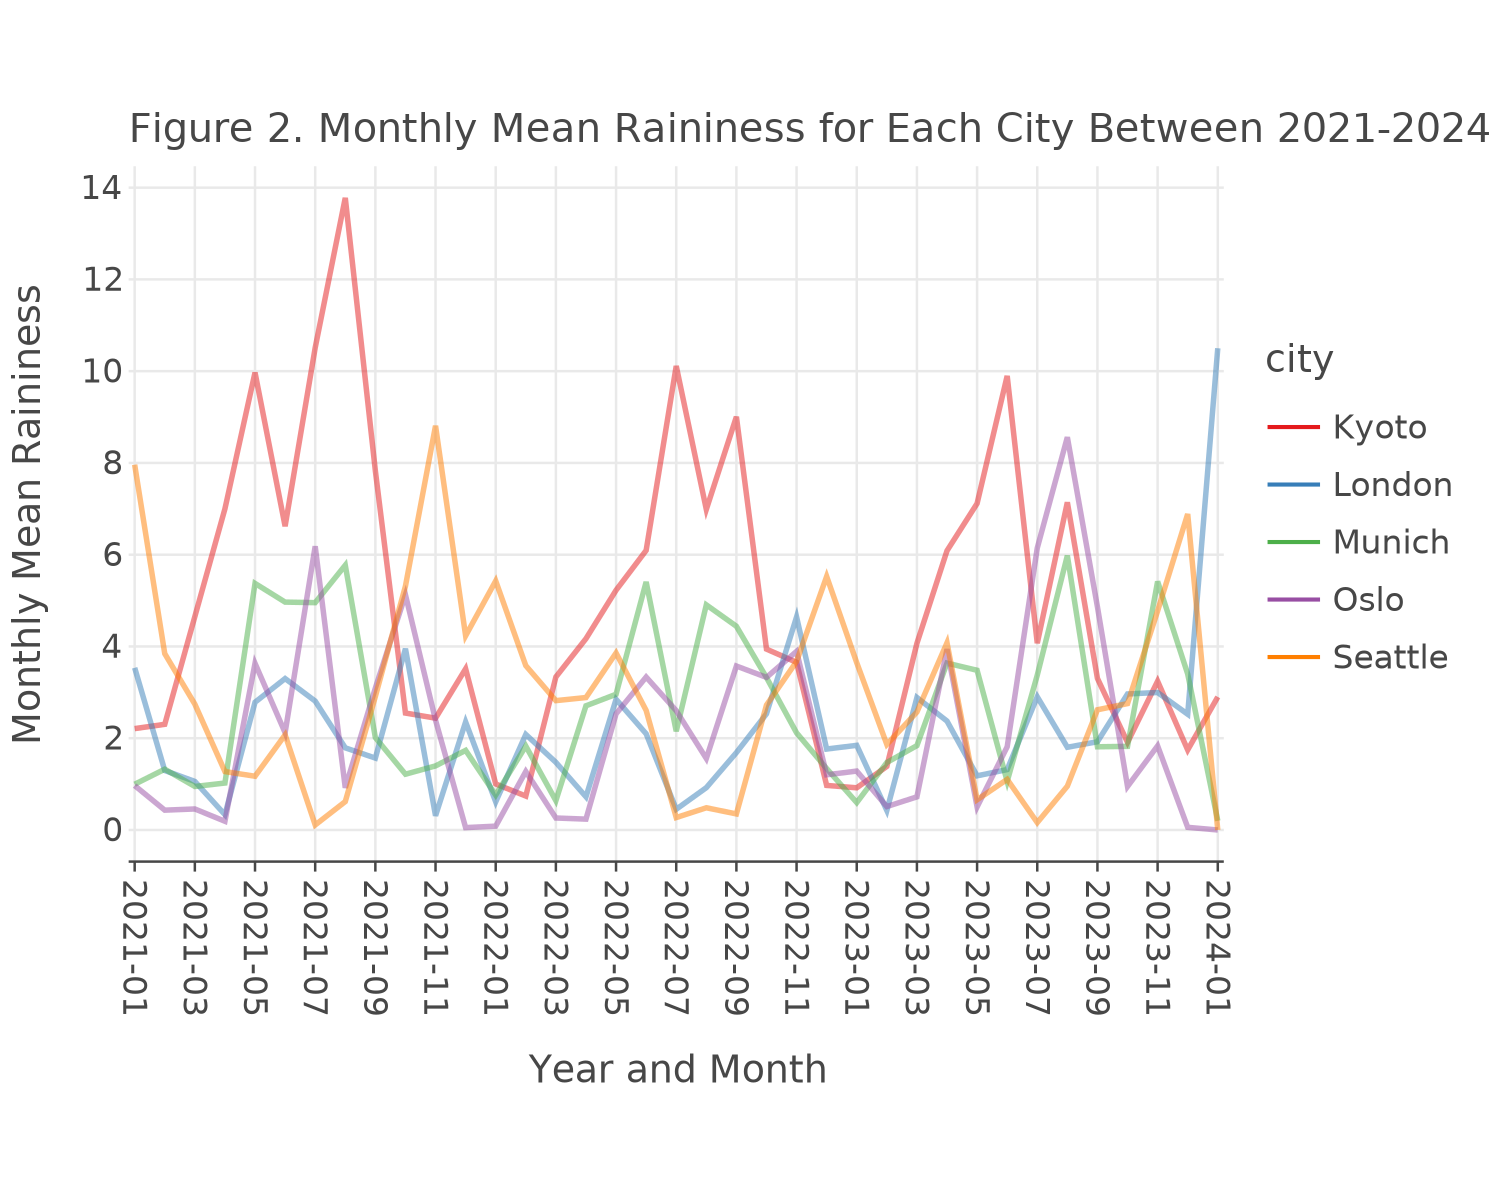

In [16]:
## Saving plot
ggsave(plot, filename='all_line.png', path='../figures', w=5, h=4, unit='in', dpi=300)
## Displaying plot
Image(filename='../figures/all_line.png') 

In [5]:
## Creating variables for Kyoto and London mean raininess data, and plotting them on a line graph
kyoto_data = get_city_data(monthly_avg, 'Kyoto')
london_data = get_city_data(monthly_avg, 'London')
plot1_data = pd.concat([kyoto_data, london_data], ignore_index=True)

plot1 = (
    ggplot(plot1_data) +
    aes(x='year_month', y='monthly_mean_raininess', color='city') +
    geom_line(size=1, alpha=0.5) +
    ggtitle(f'Figure 3. Monthly Mean Raininess: Kyoto vs. London (2021-2024)') +
    xlab('Date') +
    ylab('Monthly Mean Raininess'))

plot1

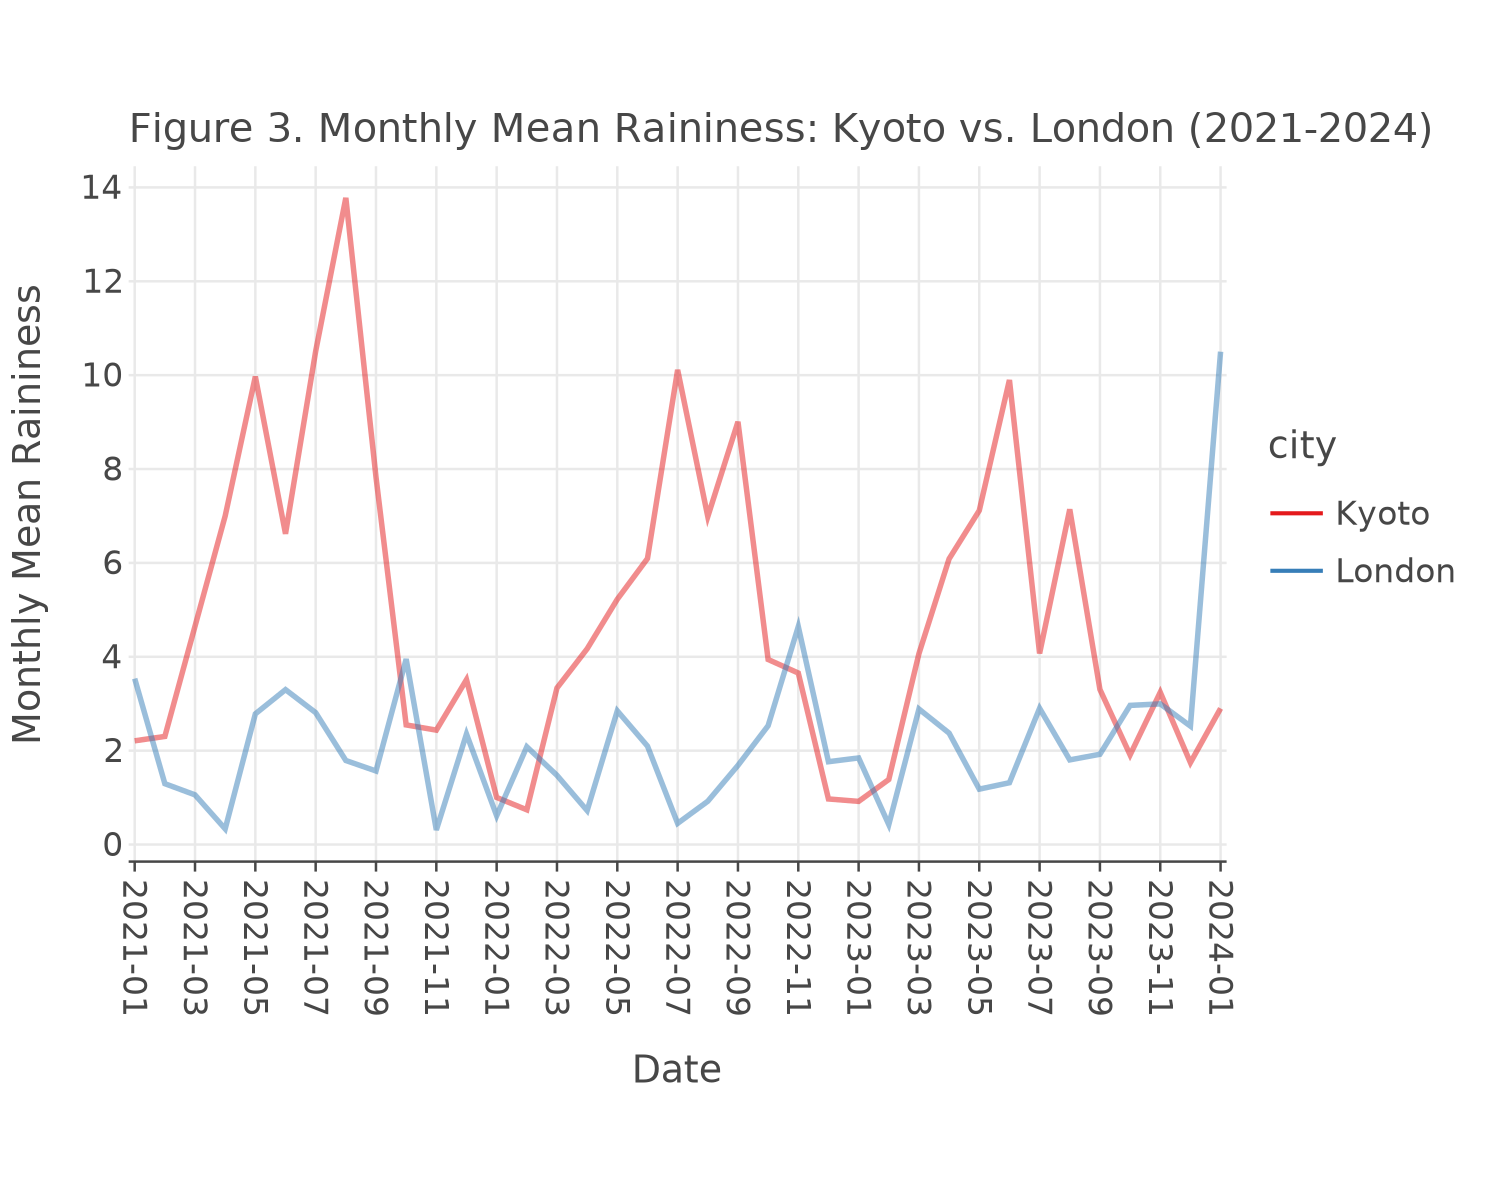

In [11]:
## Saving plot
ggsave(plot1, filename='kyoto_london.png', path='../figures', w=5, h=4, unit='in', dpi=300)
## Displaying plot
Image(filename='../figures/kyoto_london.png') 

Fig. 3 visualizes the difference in monthly mean raininess between Kyoto, which has one of the highest mean raininess, and London, which has one of the lowest. Even at both of their peaks - Kyoto at 13.8mm in August 2021, London at 10.5mm in January 2024 - Kyoto is still rainier by 3.3mm of rain. This suggests that both our hypotheses are likely to be proven wrong, as there is at least one city that London's raininess doesn't follow a similar pattern to, and that city is rainier than London.

In [6]:
## Calculating the mean raininess of each city, to map out the cities' raininess
df = pd.read_csv('../data/all_city_rain_df.csv')

mean_raininess_per_city = df.groupby(['country','city'])['raininess'].mean().reset_index()

mean_raininess_per_city.columns = ['country', 'city', 'mean_raininess']

print(mean_raininess_per_city)
## Saving mean raininess data
mean_raininess_per_city.to_csv('../data/mean_raininess_per_city.csv', index=False)

  country     city  mean_raininess
0      DE   Munich        2.731934
1      GB   London        2.016423
2      JP    Kyoto        5.004197
3      NO     Oslo        2.245985
4      US  Seattle        2.976825


In [7]:
## Reading the centroid and mean raininess data into variables to merge them into the combined_df
## Aiming to use this df for my livemap
cen = pd.read_csv('../data/centroid_data.csv')
mean_rain = pd.read_csv('../data/mean_raininess_per_city.csv')

combined_df = pd.merge(cen, mean_rain, on='city', how='inner')

print(combined_df)

combined_df.to_csv('../data/combined_df.csv', index=False)

      city found name                                     geometry country  \
0   Munich     Munich                     POINT (11.5258 48.15457)      DE   
1   London     London  POINT (-0.144055305103075 51.4893338084221)      GB   
2    Kyoto      Kyoto    POINT (135.755607113242 35.0210405141115)      JP   
3     Oslo       Oslo     POINT (10.775728858116 59.9723978340626)      NO   
4  Seattle    Seattle   POINT (-122.313062421052 47.6189685612917)      US   

   mean_raininess  
0        2.731934  
1        2.016423  
2        5.004197  
3        2.245985  
4        2.976825  


### Figure 4.
#### <i> Livemap of cities and raininess, where point size is defined by mean raininess </i>

In [8]:
## Plotting mean raininess data on a livemap
centroids = geocode_cities(combined_df['city']).get_centroids()

centroids.loc[centroids['city'] == 'Munich', 'geometry'] = Point(11.5258, 48.15457)

lats = [0 * y for y in range(4)]

p = ggplot() + ggsize(800, 500)

plot = (
    p + 
    geom_livemap(zoom=2.75) +
    geom_hline(aes(yintercept=lats), color='#e0218a', linetype=2, size=1) +
    geom_point(aes(size='mean_raininess', color='city'), 
               show_legend=True,  
               data=combined_df,
               map=centroids, 
               map_join="city", 
               tooltips=layer_tooltips().title("@city"))
)

plot

I have visualized the overall mean raininess of cities between Jan 2021 and Jan 2024 and plotted them on the above livemap, where the point sizes reflect how large the mean sum of rain is. Although this is not the final variable which I will be using to reach my final conclusion, the mean raininess helps visualize the levels of rain that is typical to these cities, giving us an idea of what to expect in the next steps of the analysis;

i.e., London seems to have one of the lowest mean raininesses

In [9]:
## Saving the map under figures
ggsave(plot, filename='raininess_map.html', path='/files/ds105a-2024-w06-summative-deyavuz/figures')

'/files/ds105a-2024-w06-summative-deyavuz/figures/raininess_map.html'

In the next notebook, to analyze the data, I will be ranking the cities by:
- every single day, number 1 in raininess

And then:
- calculating how many times London is number 1

Click [here](https://github.com/lse-ds105/ds105a-2024-w06-summative-deyavuz?tab=readme-ov-file#order-of-notebooks) to navigate back to the Order of Notebooks table!